# K-Nearest Neighbors

In [72]:
#%pip install palmerpenguins

import sys
from pathlib import Path

# Start at the current directory
root = Path().resolve()

while not (root / "src" / "rice_ml").exists() and root != root.parent:
    root = root.parent

sys.path.append(str(root / "src"))

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from palmerpenguins import load_penguins

from rice_ml.supervised_learning.knn import KNN
from rice_ml.supervised_learning.preprocess import train_test_split, standardize_fit, standardize_transform

sns.set_theme()

np.random.seed(123)

### Loading and preparing the dataset

In [73]:
penguins = load_penguins()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


We are using the Penguins dataset, which we are already familiar with from our implementation of the Perceptron. As previously stated, Each row is an observation of a penguin, as long as some characteristics of that penguin: this includes information about its species, sex, bill legnth, flipper length, etc.

In [74]:
# Select features (X) and target (y), and drop missing values

# Columns we will use as numeric features
feature_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
target_col = "species"

# Keep only the columns we care about
penguins_subset = penguins[feature_cols + [target_col]].copy()

# Drop rows with any missing values in these columns
penguins_clean = penguins_subset.dropna()

print("Original shape:", penguins.shape)
print("After selecting columns and dropping NAs:", penguins_clean.shape)

# Build feature matrix X and label vector y
X = penguins_clean[feature_cols].to_numpy(dtype=float)
y = penguins_clean[target_col].to_numpy()

print("Shape:", X.shape)  # (n_samples, n_features)


Original shape: (344, 8)
After selecting columns and dropping NAs: (342, 5)
Shape: (342, 4)


KNN can be used for many tasks, including regression and recommendation algorithms. We will use it in this notebook for a classification task. Let us treat the species of penguin as the target vector (y), which we will predict using a feature vector of the penguin's measurements (X) comprising of bill length, bill depth, flipper length, and body mass.

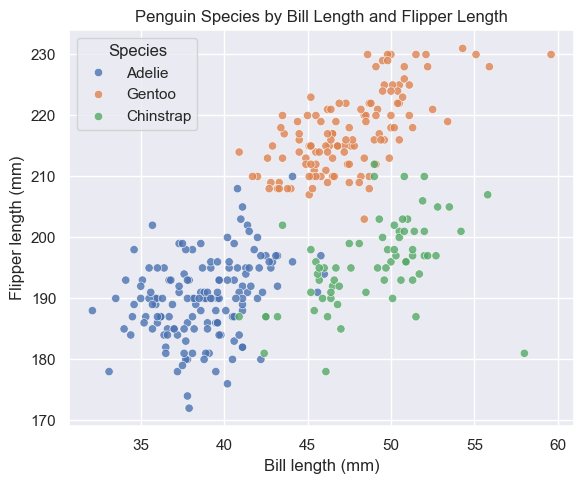

In [75]:
# Scatter plot of bill length vs flipper length, colored by species

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=penguins_clean,
    x="bill_length_mm",
    y="flipper_length_mm",
    hue="species",
    alpha=0.8
)

plt.title("Penguin Species by Bill Length and Flipper Length")
plt.xlabel("Bill length (mm)")
plt.ylabel("Flipper length (mm)")
plt.legend(title="Species")
plt.tight_layout()
plt.show()

Here, we have a scatter plot of flipper and bill length of the penguins, colored by species. We can see that the species form distinct clusters in the graph space, suggesting that KNN is likely to be effective. However, there is also notable overlap, especially between Adelie and Chinstrap penguins, which could cause uncertainty for KNN classification.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    random_state=12
)

print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape: ", y_test.shape)

print("\nTrain species counts:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for label, count in zip(unique_train, counts_train):
    print(f"  {label}: {count}")

print("\nTest species counts:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for label, count in zip(unique_test, counts_test):
    print(f"  {label}: {count}")

X_train shape: (274, 4)
X_test shape:  (68, 4)
y_train shape: (274,)
y_test shape:  (68,)

Train species counts:
  Adelie: 122
  Chinstrap: 52
  Gentoo: 100

Test species counts:
  Adelie: 29
  Chinstrap: 16
  Gentoo: 23


After splitting our training and testing data, we can confirm that we are predicting on 4 feature variables and that we are training on 274 penguin observations and testing on 68 testing data.

In [77]:
# Standardize features using our helper functions


# Fit standardization parameters on the training data only
mean_train, std_train = standardize_fit(X_train)

# Apply the same transformation to both train and test sets
X_train_std = standardize_transform(X_train, mean_train, std_train)
X_test_std  = standardize_transform(X_test,  mean_train, std_train)

print("Standardized X_train mean (per feature):", X_train_std.mean(axis=0))

Standardized X_train mean (per feature): [-1.70463805e-15  1.40013710e-15  5.48628458e-16 -2.00164297e-16]
Standardized X_train std  (per feature): [1. 1. 1. 1.]


Finally, we can standardize the features to prevent features with larger numeric scaled (e.g, body mass) from dominating the classification. This makes distance a more meaningful and effective way of classifying penguins into their unique species.

### Training the KNN Classifier

In [83]:
# Create a KNN classifier
knn_clf = KNN(
    k=5,
    task="classification",
    distance="euclidean",
    weights="uniform",
    return_neighbors=False
)

# Fit on the training data
knn_clf.fit(X_train_std, y_train)

# Predict on the test data
y_pred = knn_clf.predict(X_test_std)

# Compute accuracy: fraction of correct predictions
accuracy = np.mean(y_pred == y_test)

print("First 10 predicted labels: ", y_pred[:10])
print("First 10 true labels:      ", y_test[:10])
print(f"\nTest accuracy: {accuracy:.3f}")


First 10 predicted labels:  ['Chinstrap' 'Adelie' 'Chinstrap' 'Chinstrap' 'Gentoo' 'Gentoo' 'Gentoo'
 'Chinstrap' 'Adelie' 'Chinstrap']
First 10 true labels:       ['Chinstrap' 'Adelie' 'Chinstrap' 'Chinstrap' 'Gentoo' 'Gentoo' 'Gentoo'
 'Chinstrap' 'Adelie' 'Chinstrap']

Test accuracy: 0.985


Now that our dataset is prepared, we can create a KNN classifier model. We start by using k = 5, which means that we classify penguins using its 5 closest neighbors. We are also using Eudclidian (straight-line) distance and weighting the influence of all neighbors equal.

Our initial test accuracy is already high, even without fine tuning the parameters of the model (such as changing k). It is possible that other ditances or weighing methods may be even more effective.

Let's get a closer look at how decisions are actually being made.

In [116]:
# Inspect the k nearest neighbors for some test penguins

knn_debug = KNN(
    k=5,
    task="classification",
    distance="euclidean",
    weights="uniform",
    return_neighbors=True
)
knn_debug.fit(X_train_std, y_train)

def inspect_test_example(test_index: int) -> None:
    """
    Print the true label, predicted label, and neighbor details
    for a single test example.
    Uses standardized features for distance calculations.
    """
    x_query_std = X_test_std[test_index]
    y_true = y_test[test_index]

    # KNN expects 2D input
    y_pred, (idxs, dists) = knn_debug.predict(x_query_std.reshape(1, -1))

    neighbor_idx = idxs[0]
    neighbor_dists = dists[0]
    neighbor_labels = y_train[neighbor_idx]

    print(f"Test index: {test_index}")
    print(f"True species:      {y_true}")
    print(f"Predicted species: {y_pred[0]}")
    print("\nNearest neighbors (in the training set):")

    neighbor_df = pd.DataFrame({
        "train_index": neighbor_idx,
        "distance": neighbor_dists,
        "neighbor_species": neighbor_labels,
    }).sort_values("distance")

    display(neighbor_df.reset_index(drop=True))
    print("-" * 60)


# Get predictions for the whole test set
y_pred_all, _ = knn_debug.predict(X_test_std)

# Find misclassified and correctly classified indices
mis_idx = np.where(y_pred_all != y_test)[0]
correct_idx = np.where(y_pred_all == y_test)[0]

# Inspect a misclassified example
for i in mis_idx[:2]:
    inspect_test_example(int(i))

# Inspect a correctly classified example
if len(correct_idx) > 0:
    inspect_test_example(int(correct_idx[0]))



Test index: 51
True species:      Chinstrap
Predicted species: Adelie

Nearest neighbors (in the training set):


,train_index,distance,neighbor_species
0,261,0.146409,Adelie
1,27,0.562878,Chinstrap
2,28,0.597180,Adelie
3,190,0.622574,Adelie
4,264,0.635982,Adelie


------------------------------------------------------------
Test index: 0
True species:      Chinstrap
Predicted species: Chinstrap

Nearest neighbors (in the training set):


,train_index,distance,neighbor_species
0,53,0.317580,Chinstrap
1,94,0.458231,Chinstrap
2,238,0.507291,Chinstrap
3,230,0.526428,Chinstrap
4,243,0.551939,Chinstrap


------------------------------------------------------------


We can see that in the first instance, we are examining a Chinstrap penguin that is being misclassified as an Adelie penguin. We initially identified those two species as potentially causing confusion for the KNN as there is significant overlap between the physical characteristics of those penguins. Since most of its 5 neighbors are Adelie penguins, our KNN classifier is misclassifying this penguin.

In the second instance, all 5 of our penguin's closest neighbors are Chinstraps, causing it to be correctly classified as a Chinstrap penguin.

Our KNN classifier could potentially beenfit from some tweaks by altering the k or using distance based weighting.

In [ ]:
# Search over different k values and track test accuracy

k_values = list(range(1, 9, 1)) 
accuracies = []

for k in k_values:
    knn_tmp = KNN(
        k=k,
        task="classification",
        distance="euclidean",
        weights="distance",
        return_neighbors=False
    )
    # Fit on standardized training data
    knn_tmp.fit(X_train_std, y_train)

    # Predict on standardized test data
    y_pred_k = knn_tmp.predict(X_test_std)
    acc_k = np.mean(y_pred_k == y_test)
    accuracies.append(acc_k)

# Find the best k
best_idx = int(np.argmax(accuracies))
best_k = k_values[best_idx]
best_acc = accuracies[best_idx]

print("k values tested:", k_values)
print("Accuracies:     ", [round(a, 4) for a in accuracies])
print(f"\nBest k: {best_k}")
print(f"Best test accuracy: {best_acc:.4f}")



k values tested: [1, 2, 3, 4, 5, 6, 7, 8]
Accuracies:      [0.9706, 0.9706, 0.9853, 0.9853, 0.9853, 0.9853, 0.9853, 0.9853]

Best k: 3
Best test accuracy: 0.9853


Here, we pivoted to using distance based weighting and searched for values of K that would give us the highest test accuracy. We found that k values of 3 or higher yielded the highest testing accuracy, and we decided to stick with our original k value of 5 as a moderate choice that avoids the larger risk of overfitting that comes with smaller values of k.

Let us move forward with this new model.

### Testing / Prediction

In [123]:
# Train the final KNN model

# Final model (using standardized features)
knn_final = KNN(
    k=5,
    task="classification",
    distance="euclidean",
    weights="distance",
    return_neighbors=False
)

# Fit on the standardized training data
knn_final.fit(X_train_std, y_train)

# Predict on the standardized test data
y_pred_final = knn_final.predict(X_test_std)

# Overall test accuracy
final_accuracy = np.mean(y_pred_final == y_test)
print(f"Final test accuracy (k=5, distance weights, standardized): {final_accuracy:.4f}")

# Confusion matrix by species
conf_mat = pd.crosstab(
    pd.Series(y_test, name="True species"),
    pd.Series(y_pred_final, name="Predicted species")
)

print("\nConfusion matrix:")
display(conf_mat)


Final test accuracy (k=5, distance weights, standardized): 0.9853

Confusion matrix:


Predicted species,Adelie,Chinstrap,Gentoo
True species,,,
Adelie,29,0,0
Chinstrap,1,15,0
Gentoo,0,0,23


As expected, we exhibit strong accuracy (>95%) in our testing set, indicating that our KNN classifier has learned meaningful relationships between the features of penguin physical characteristics and the species of the penguin.

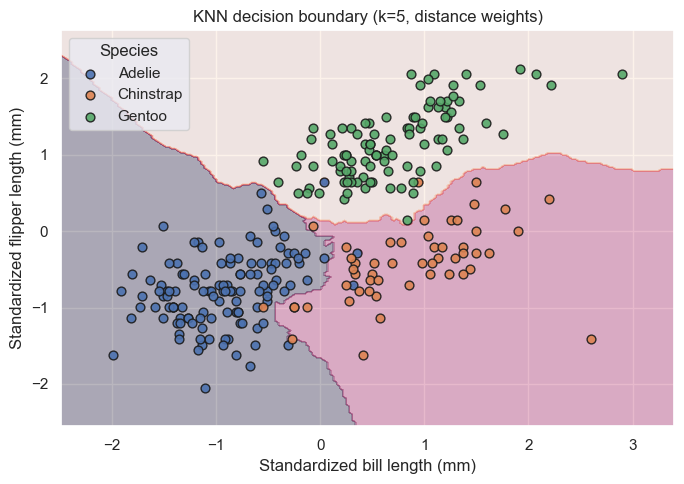

In [125]:
# Indices of the two features we want to visualize:
feat_idx = [0, 2]

X_train_2 = X_train_std[:, feat_idx]
X_test_2  = X_test_std[:, feat_idx]

# Train a KNN on just these two features
knn_vis = KNN(
    k=5,
    task="classification",
    distance="euclidean",
    weights="distance",
    return_neighbors=False
)
knn_vis.fit(X_train_2, y_train)

# Create a grid over the 2D feature space
x_min, x_max = X_train_2[:, 0].min() - 0.5, X_train_2[:, 0].max() + 0.5
y_min, y_max = X_train_2[:, 1].min() - 0.5, X_train_2[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = knn_vis.predict(grid_points)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7, 5))

# Plot decision regions
species_unique = np.unique(y_train)
species_to_int = {s: i for i, s in enumerate(species_unique)}
Z_int = np.vectorize(species_to_int.get)(Z)

plt.contourf(xx, yy, Z_int, alpha=0.3)

# Overlay training points
for species in species_unique:
    mask = (y_train == species)
    plt.scatter(
        X_train_2[mask, 0],
        X_train_2[mask, 1],
        label=species,
        alpha=0.9,
        edgecolor="k",
        s=40
    )

plt.xlabel("Standardized bill length (mm)")
plt.ylabel("Standardized flipper length (mm)")
plt.title("KNN decision boundary (k=5, distance weights)")
plt.legend(title="Species")
plt.tight_layout()
plt.show()


In this plot, we can see how our finalized KNN classifier created decision boundaries, visualizing just two features, bill length and flipper length. The irregular decision boundaries are a distuingishing factor from KNN models from Perceptrons or Multi-Layer Perceptrons as those can only create linear boundaries or parametric boundaries, respectively. By not learning weights, KNN is able to create decision boundaries dictated by the data itself.